<h3>Introduction</h3>
This notebook performs an RFM (Recency, Frequency, and Monetary) Analysis on customer transaction data to identify key customer segments and behaviors. It concludes by applying K-Means clustering to enhance business insights.



In [ ]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

<h3>Data Import and Initial Preprocessing</h3>
We begin by importing the necessary libraries and loading the dataset for analysis. Data cleaning steps will ensure the integrity of the analysis.

Dataset Link: https://www.kaggle.com/datasets/vijayuv/onlineretail/data

In [ ]:
df = pd.read_csv("/content/OnlineRetail.csv", encoding='latin-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [ ]:
df.Country.value_counts().reset_index().head(20)

,Country,count
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


In [ ]:
uk = df[df['Country']=='United Kingdom']
uk.shape

(495478, 8)

In [ ]:
uk = uk[uk['Quantity']>0]
uk.shape

(486286, 8)

In [ ]:
uk.dropna(subset=['CustomerID'],how='all',inplace=True)
uk.shape

(354345, 8)

In [ ]:
uk = uk[uk['InvoiceDate']>= "2010-12-09"]
uk.shape

(342478, 8)

In [ ]:
data= uk
data.to_csv(('/content/data.csv'))

In [ ]:
print("Summary..")
#exploring the unique values of each attributes
print("Number of transactions: ", uk['InvoiceNo'].nunique())
print("Number of products bought: ",uk['StockCode'].nunique())
print("Number of customers:", uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(uk['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Summary..
Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


**Exploratory Data Analysis**

In [ ]:
#Aggregating the Orders by Month
df_agg = uk[['InvoiceDate', 'Quantity']]
df_agg['InvoiceMonth'] = df_agg['InvoiceDate'].dt.to_period('M')
df_agg = df_agg.groupby('InvoiceMonth')['Quantity'].sum()
df_agg = df_agg.reset_index()
df_agg['InvoiceMonth'] = df_agg['InvoiceMonth'].astype(str)
df_agg.head()

,InvoiceMonth,Quantity
0,2010-12,141498
1,2011-01,278300
2,2011-02,213391
3,2011-03,276345
4,2011-04,260450


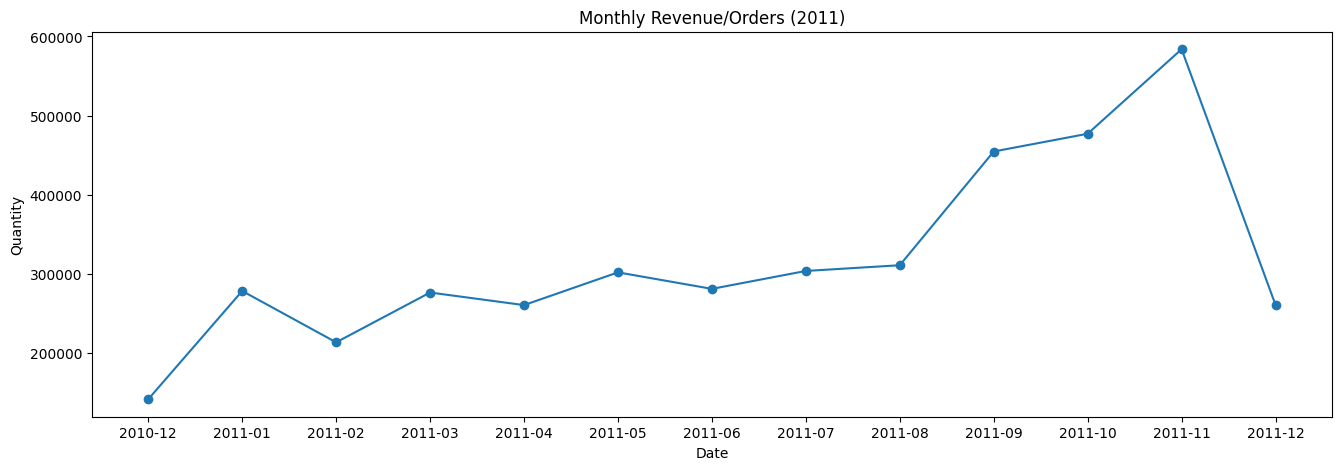

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Quantity', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()
plot_df(df_agg, x=df_agg.InvoiceMonth, y=df_agg.Quantity,title='Monthly Revenue/Orders (2011)')

<h3>RFM Analysis</h3>
RFM Analysis is a proven marketing model to segment customers based on their transaction history. We calculate the three key components:

<p>1. Recency: Days since the last purchase.</p>
<p>2. Frequency: Total number of purchases.</p>
<p>3. Monetary: Total spend per customer.</p>


In [ ]:
#The last date available in our dataset
uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [ ]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [ ]:
#create a new column called date which contains the date of invoice only
uk['date'] = uk['InvoiceDate'].dt.date

In [ ]:
uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [ ]:
#group by customers and check last date of purshace
recency_df = uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaseDate']
recency_df.head()

,CustomerID,LastPurshaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [ ]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaseDate'].apply(lambda x: (now - x).days)

In [ ]:
recency_df.head()

,CustomerID,LastPurshaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [ ]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaseDate',axis=1,inplace=True)

In [ ]:
recency_df.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


In [ ]:
# drop duplicates
uk_copy = uk
uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


In [ ]:
#create column total cost
uk['TotalCost'] = uk['Quantity'] * uk['UnitPrice']

In [ ]:
monetary_df = uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


In [ ]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


In [ ]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,10,658.89
2,12748.0,0,196,3739.23
3,12749.0,3,5,98.35
4,12820.0,3,4,58.20


In [ ]:
copy_rfm = rfm_df.copy()
copy_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,10,658.89
2,12748.0,0,196,3739.23
3,12749.0,3,5,98.35
4,12820.0,3,4,58.20


<h3>RFM Segmentation</h3>
We assign RFM quartile scores and calculate an RFM Score for each customer to determine their value to the business.

In [ ]:
quantiles = copy_rfm.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = copy_rfm.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,10,658.89,1,1,1
2,12748.0,0,196,3739.23,1,1,1
3,12749.0,3,5,98.35,1,2,2
4,12820.0,3,4,58.20,1,2,2


In [ ]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,10,658.89,1,1,1,111
2,12748.0,0,196,3739.23,1,1,1,111
3,12749.0,3,5,98.35,1,2,2,122
4,12820.0,3,4,58.20,1,2,2,122


In [ ]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,10,658.89,1,1,1,111,3
2,12748.0,0,196,3739.23,1,1,1,111,3
3,12749.0,3,5,98.35,1,2,2,122,5
4,12820.0,3,4,58.20,1,2,2,122,5


In [ ]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  25
Lost Customers:  208
Lost Cheap Customers:  353


In [ ]:
# Setting up the label for each client and adding the column "Label" to the dataframe

label = [0] * len(segmented_rfm)
for i in range(0,len(segmented_rfm)):

    if segmented_rfm['RFM_Segment'][i] == '111':
        label[i] = "Best Customers"

    elif segmented_rfm['RFM_Segment'][i] == '134' :
        label[i] = "Almost Lost"

    elif segmented_rfm['RFM_Segment'][i] == '344':
        label[i] = "Lost Customers"

    elif segmented_rfm['RFM_Segment'][i] == '444':
        label[i] = "Lost Cheap Customers"

    elif segmented_rfm['F_quartile'][i] == 1:
        label[i] = "Loyal Customers"

    elif segmented_rfm['M_quartile'][i] == 1:
        label[i] = "Big Spenders"

    else:
        label[i] = "Others"

In [ ]:
# Adding the 'Label' column to our dataframe
segmented_rfm['Label'] = label

In [ ]:
# Count the frequency that a value occurs in a dataframe column for the labels.
segmented_rfm['Label'].value_counts()

,count
Label,
Others,2122
Big Spenders,403
Loyal Customers,396
Best Customers,356
Lost Cheap Customers,353
Lost Customers,208
Almost Lost,25


<h3>Customer Insights</h3>
The following cells display customer segment counts, including "Best Customers," "Loyal Customers," and "Lapsed Customers."

In [ ]:
segmented_rfm

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score,Label
0,12346.0,325,1,77183.60,4,4,1,441,9,Big Spenders
1,12747.0,2,10,658.89,1,1,1,111,3,Best Customers
2,12748.0,0,196,3739.23,1,1,1,111,3,Best Customers
3,12749.0,3,5,98.35,1,2,2,122,5,Others
4,12820.0,3,4,58.20,1,2,2,122,5,Others
...,...,...,...,...,...,...,...,...,...,...
3858,18280.0,277,1,23.70,4,4,3,443,11,Others
3859,18281.0,180,1,5.04,4,4,4,444,12,Lost Cheap Customers
3860,18282.0,7,2,38.25,1,3,3,133,7,Others
3861,18283.0,3,16,66.75,1,1,2,112,4,Loyal Customers


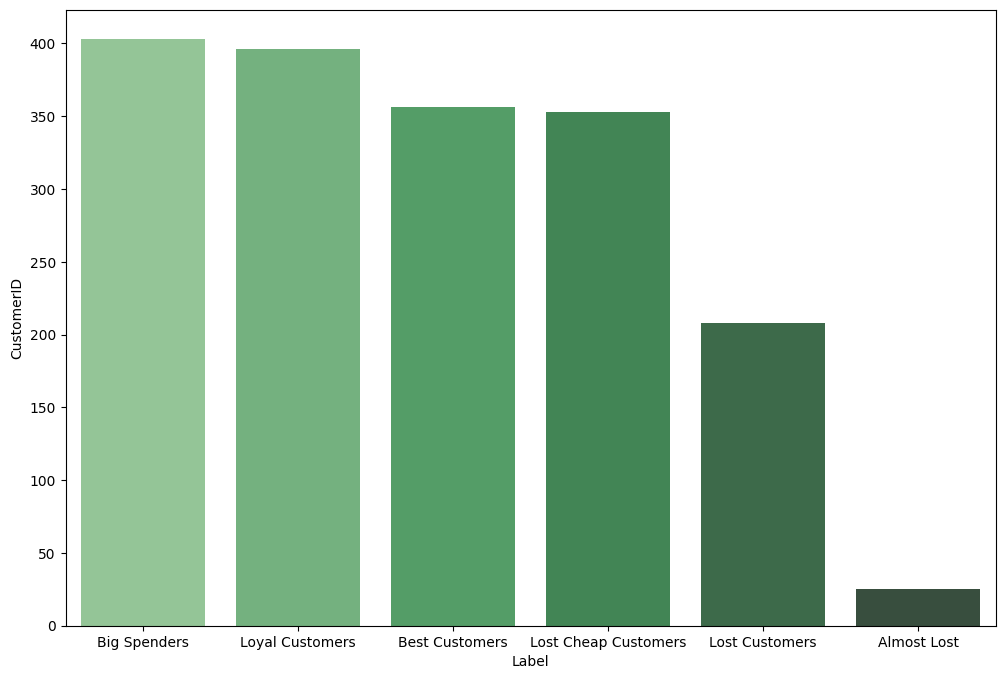

In [ ]:
import seaborn as sns
sq1=segmented_rfm.groupby('Label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sq1.drop([0],inplace=True)
sns.barplot(data=sq1, x="Label", y="CustomerID", palette = "Greens_d");

<h3>K-Means Clustering for Customer Segmentation</h3>
We preprocess the data and apply K-Means clustering to further segment the customers into distinct groups, offering valuable insights for marketing strategies.

Preprocess

In [ ]:
scaler=StandardScaler()
scaled=scaler.fit_transform(rfm_df)

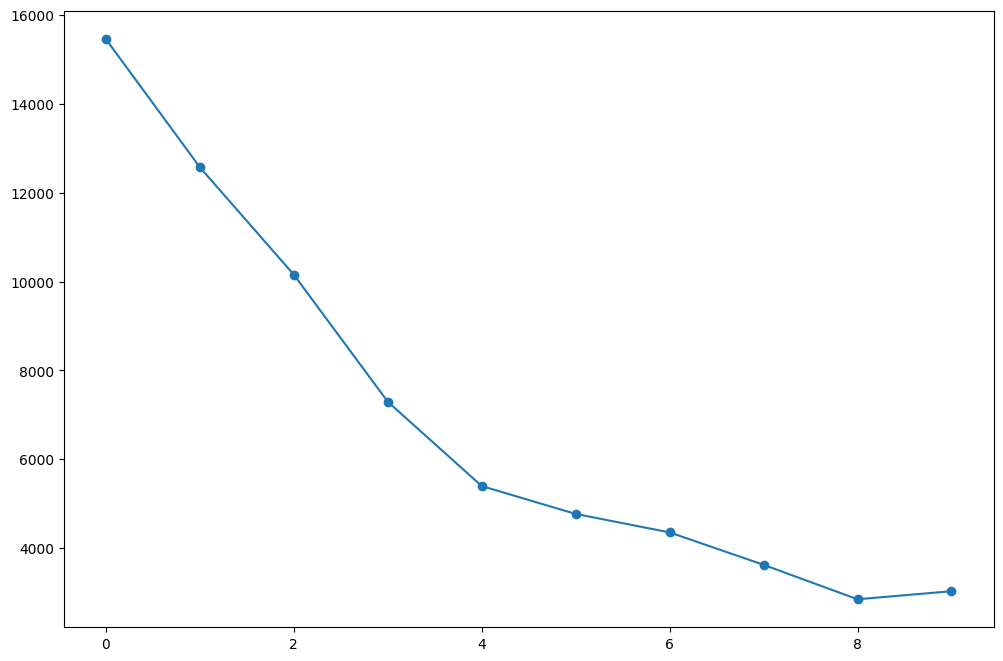

In [ ]:
from sklearn.cluster import KMeans

inertia=[]

for i in np.arange(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(12,8))
plt.plot(inertia, marker="o")

In [ ]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
rfm_df["Clusters"]=(kmeans.labels_+1)

In [ ]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,Clusters
0,12346.0,325,1,77183.60,3
1,12747.0,2,10,658.89,2
2,12748.0,0,196,3739.23,2
3,12749.0,3,5,98.35,2
4,12820.0,3,4,58.20,2
...,...,...,...,...,...
3858,18280.0,277,1,23.70,3
3859,18281.0,180,1,5.04,1
3860,18282.0,7,2,38.25,1
3861,18283.0,3,16,66.75,1


In [ ]:
final = rfm_df.groupby("Clusters")[['Recency', 'Frequency', 'Monetary']].mean()
final

,Recency,Frequency,Monetary
Clusters,,,
1,44.503243,4.621271,396.059903
2,42.498980,5.190347,223.024242
3,243.549412,1.477647,205.360459


In [ ]:
def func(row):
    if row["Clusters"]==1:
        return 'Big Spenders'
    elif row["Clusters"]==3:
        return 'Lapsed Cx'
    else:
        return 'Avg. Cx'

In [ ]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,Clusters
0,12346.0,325,1,77183.60,3
1,12747.0,2,10,658.89,2
2,12748.0,0,196,3739.23,2
3,12749.0,3,5,98.35,2
4,12820.0,3,4,58.20,2
...,...,...,...,...,...
3858,18280.0,277,1,23.70,3
3859,18281.0,180,1,5.04,1
3860,18282.0,7,2,38.25,1
3861,18283.0,3,16,66.75,1


In [ ]:
rfm_df['ClusterGroup']=rfm_df.apply(func, axis=1)

In [ ]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,Clusters,ClusterGroup
0,12346.0,325,1,77183.60,3,Lapsed Cx
1,12747.0,2,10,658.89,2,Avg. Cx
2,12748.0,0,196,3739.23,2,Avg. Cx
3,12749.0,3,5,98.35,2,Avg. Cx
4,12820.0,3,4,58.20,2,Avg. Cx
...,...,...,...,...,...,...
3858,18280.0,277,1,23.70,3,Lapsed Cx
3859,18281.0,180,1,5.04,1,Big Spenders
3860,18282.0,7,2,38.25,1,Big Spenders
3861,18283.0,3,16,66.75,1,Big Spenders


In [ ]:
result=rfm_df.ClusterGroup.value_counts()

<h3>Final Insights and Visualization</h3>
Visualizations and final results are presented to summarize customer segments and their characteristics.

In [ ]:
result

,count
ClusterGroup,
Big Spenders,1542
Avg. Cx,1471
Lapsed Cx,850


<Axes: ylabel='ClusterGroup'>

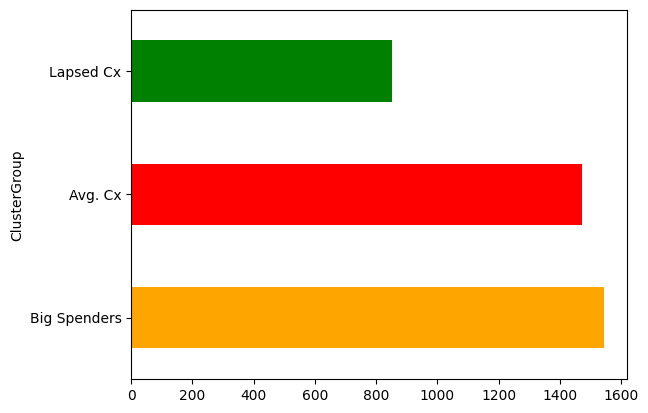

In [ ]:
result.plot(kind="barh", color=["Orange","Red","Green"])

In [ ]:
total_customers = len(rfm_df)
lapsed_cx_percentage = (len(rfm_df[rfm_df['ClusterGroup'] == 'Lapsed Cx']) / total_customers) * 100
avg_cx_percentage = (len(rfm_df[rfm_df['ClusterGroup'] == 'Avg. Cx']) / total_customers) * 100
big_spenders_percentage = (len(rfm_df[rfm_df['ClusterGroup'] == 'Big Spenders']) / total_customers) * 100

In [ ]:
print(f"Percentage of Lapsed Customers: {lapsed_cx_percentage:.2f}%")
print(f"Percentage of Average Customers: {avg_cx_percentage:.2f}%")
print(f"Percentage of Big Spenders: {big_spenders_percentage:.2f}%")

Percentage of Lapsed Customers: 22.00%
Percentage of Average Customers: 38.08%
Percentage of Big Spenders: 39.92%
